# Code Setup

In [163]:
GOOGLE_COLAB = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')    

In [165]:
if GOOGLE_COLAB:
    #import necessary python files
    import sys
    import os
    
    drive_dir = '/content/drive/MyDrive/PouchPrint-IROS-2024'
    
    sys.path.append(os.path.join(drive_dir, 'python_READ_ONLY'))
    
    # specify where all data is stored
    data_folder = os.path.join(drive_dir, 'python_READ_ONLY', 'data-raw')
else:
    # specify where all data is stored
    data_folder = './data-raw'

In [166]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import utils_aruco
import utils_icp
import copy
from utils_data_process import *
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.image as mpimg
# from scipy.optimize import curve_fit

figures_dir = 'C:/Users/harry/Desktop/research_sync/IROS 2024/figures'
# plt.rcParams['mathtext.fontset'] = 'custom'

plt.rcParams['mathtext.default'] = 'regular'  # Use regular text for mathtext by default
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

# Optionally, you can also set the default font family to Arial for consistency
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fontsize_main = 20
fontsize_legend = 14
# import sys
# import importlib
# importlib.reload(sys.modules['utils_data_process'])
plt.rcParams['font.size'] = fontsize_main
from IPython.display import display


In [167]:
fig_all, ax_all = plt.subplots(3,3,figsize=(14,12),gridspec_kw={'wspace': 0.4, 'hspace': 0.2})
plt.close(fig_all)


# Exp-force


In [168]:
result_name_arr = [
    
    'exp_3_1_force_new_20240908_11-50-29_diamond', # diamond-pos
    '', # diamond-neg,
    'exp_3_1_force_new_20240908_12-41-42_bidir-rect-pos-new',#plot
    'exp_3_1_force_new_20240908_13-20-48_bidir-rect-neg-new', #plot
    # 'exp_3_1_force_new_20240907_19-58-03_bidir-rect-pos', # bidir-rect pos
    # 'exp_3_1_force_new_20240907_21-08-31_bidir-rect-neg', # bidir-rect neg

    # bidir compound
    # 'exp_3_1_force_new_20240907_15-12-51_bidir-compound-pos',
    'exp_3_1_force_new_20240907_17-58-39_bidir-compound-pos-new',#plot
    'exp_3_1_force_new_20240907_17-13-27_bidir-compound-neg'#plot
    
]
no_camera = False
tag_offset_dict = {
    1: {
        'rot': -180,
        'disp': [-0,-3.25]
    }
}
ids=[0, 1, 2]
values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                          tag_offset_dict=tag_offset_dict,
                                                                                                          no_camera=no_camera)

found prior buffer, loading from ./data-raw\exp_3_1_force_new_20240908_11-50-29_diamond\processed\load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at ./data-raw\exp_3_1_force_new_20240908_11-50-29_diamond\processed\frame_1.png. Skipping...
Image already exists at ./data-raw\exp_3_1_force_new_20240908_11-50-29_diamond\processed\frame_1000.png. Skipping...
loaded keys:  ['force_omega', 'info_CYCLE_DONE', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'camera_1', 'camera_0', 'camera_time']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'angle_wrt_horiz', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])
found prior buffer, loading from ./data-raw\exp_3_1_force_new_20240908_12-41-42_bidir-rect-pos-new\processed\load_data.p

n cycle 10 cycle len 100
ii 0 force 0.0 1192.0
max 32.71704
n cycle 10 cycle len 100
ii 2 force 0.0 1157.0
max 22.14348
n cycle 10 cycle len 100
ii 4 force 0.0 969.0
max 13.713059999999993


C:\Users\harry\AppData\Local\Temp\ipykernel_30548\3880080664.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


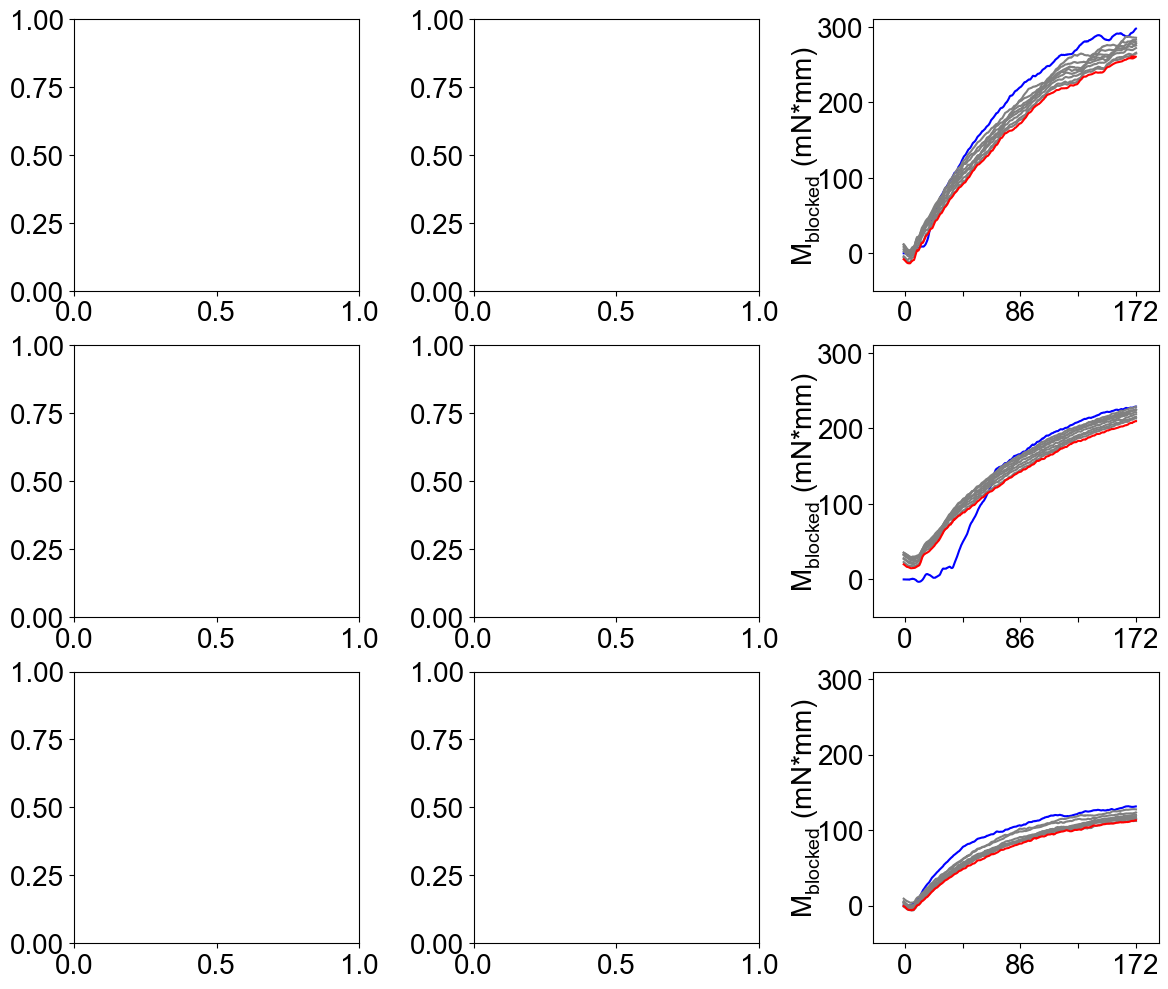

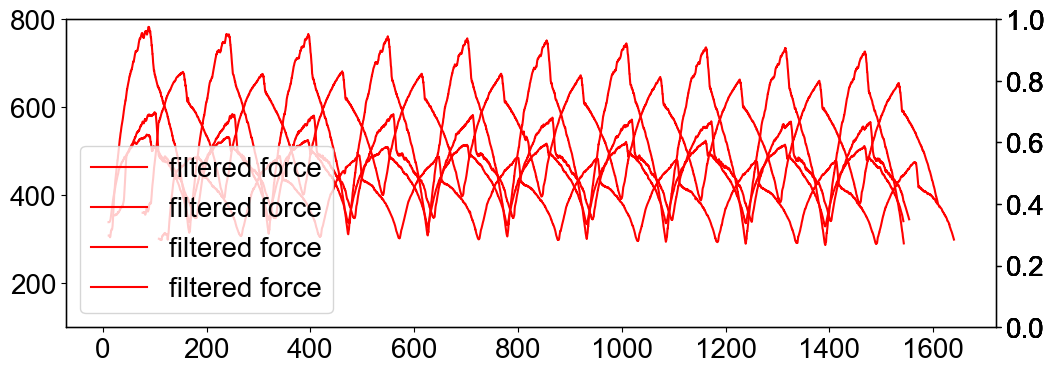

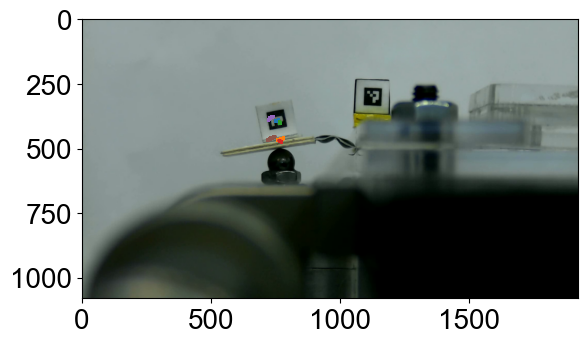

In [169]:
ForceScale = 0.079  #mN/mV
ForceScaleUp = 0.079-.01 # (increasing pressure)
ForceScaleDown = 0.079 + 0.01 # (decresasing pressure)
l_equiv = np.array([9.1, 10.4, 9.6]) 

base_angle = 0
import scipy
def filter_force(time, chan, ax):
    chan = np.copy(chan)
    kernWidth = 50
    kernel = np.zeros(2*kernWidth)  # pad with zeros to make causal
    kernel[kernWidth:] = 1/kernWidth
    chan=scipy.signal.medfilt(chan,5)  # median over 5 samples

    # ax.plot(time, chan)
    
    chan = np.convolve(chan,kernel)
    chan = chan[kernWidth:np.size(chan)-kernWidth+1]  # truncate leading/trailing convolution
    return chan
    
plt.rcParams['font.size'] = 20
n_cycle = 10

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(12,4))
if not no_camera:
    fig, ax_img = plt.subplots()
    fig_force, ax_force = plt.subplots(3, 3, figsize=(14,12),gridspec_kw={'wspace': 0.4, 'hspace': 0.2})
    
if not no_camera:
    
    img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1000.png'))
    ax_img.imshow(img)

data_export = []
for _ in range(6):
    data_export.append([])
    for _ in range(10):
        data_export[-1].append({'Pressure': np.array([]), 'PWM_values': np.array([])})

data_export_disp = []
for _ in range(6):
    data_export_disp.append([])
    for _ in range(10):
        data_export_disp[-1].append({'Pressure': np.array([]), 'Disp-X': np.array([]),'Disp-Y': np.array([])})


for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    if len(values_dict) == 0:
        continue

    if not no_camera:
        camera_scale_single = 3 / camera_data_dict['corners_len'][1][0]
    # r_val = merge_PWM(values_dict['regulator_PWM2'], values_dict['regulator_PWM3'])
    r_val = values_dict['regulator_PWM7']
    r_time = times_dict['regulator_PWM7']
    ax = ax_ori
    # ax.plot(times_dict['force_omega'], values_dict['force_omega'])
    # df = pd.DataFrame({'Time': times_dict['force_omega'], 'Force': values_dict['force_omega']})
    # df.to_csv(f'data_export/force/callibration.csv', index=False)

    force_filtered = filter_force(times_dict['force_omega'], values_dict['force_omega'], ax)
    force_filtered[0:50] = force_filtered[51]
 
    ax.plot(times_dict['force_omega'], force_filtered, color='red', label='filtered force')
    if not no_camera:
        ax1 = ax.twinx()
        # ax1.plot(camera_data_dict['t'][1],  (camera_data_dict['centroid'][1][:, 0] -  camera_data_dict['centroid'][1][0, 0])*camera_scale[0], label='rel disp X')
        # ax1.plot(camera_data_dict['t'][1],  -1 * (camera_data_dict['centroid'][1][:, 1] - camera_data_dict['centroid'][1][0, 1])*camera_scale[0], label='rel disp Y')
        # ax1.legend()
    ax.set_ylim(100, 800)
    # ax.set_xlim(0, 200)

    if ii % 2 == 1:
        continue
    
    ax.legend()
    if not no_camera:
        cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
    
        ax = ax_img
        ax.scatter(
                camera_data_dict['centroid'][1][:, 0], 
                camera_data_dict['centroid'][1][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1
            )
        ax.scatter(
                camera_data_dict['centroid_offset'][1][:, 0], 
                camera_data_dict['centroid_offset'][1][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1
            )
    pwm_filtered = np.copy(force_filtered - force_filtered[0])
    force_filtered = (force_filtered - force_filtered[0]) * ForceScaleUp 
    t_cycle_f, cycle_start_idx_f = calc_cycle(n_cycle, times_dict['force_omega'], r_time) 

    print('ii', ii, 'force', np.min(values_dict['force_omega']), np.max(values_dict['force_omega']))
    print('max', np.max(force_filtered))
    # for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
    for i in range(n_cycle) :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_force[ii//2][0]   
        start_idx = cycle_start_idx_f[i]
        end_idx = cycle_start_idx_f[i+1]
        
        cur_t = np.copy(t_cycle_f[start_idx:end_idx] - t_cycle_f[start_idx])
        cur_f = np.copy(force_filtered[start_idx:end_idx])
        # cur_f -= force_[0]
        # print('data export', len(data_export), ii//2, i)
        
        cur_pressure = map_range(cur_t, np.min(cur_t), np.max(cur_t), 
                             0, 
                             172)
        if ii % 2 == 1:
            sign = 1
        else:
            sign = 1
        data_export[ii][i]['Pressure'] = np.append(data_export[ii][i]['Pressure'], sign*cur_pressure)
        data_export[ii][i]['PWM_values'] = np.append(data_export[ii][i]['PWM_values'], sign*pwm_filtered[start_idx:end_idx])

        cur_t = cur_t[:3750]
        cur_f = cur_f[:3750]
        line = ax.plot(
                sign*cur_t ,
                sign*cur_f* l_equiv[ii//2],
                linestyle='-',
                label=f'#{i+1}',
                color=color
                )
        ax = ax_all[ii//2][2]
        ax.plot(
                sign*cur_t ,
                sign*cur_f* l_equiv[ii//2],
                linestyle='-',
                label=f'#{i+1}',
                color=color
                )
        if ii == 0:
            lines.append(line)
        if not no_camera:
            
            start_idx = camera_data_dict['cycle_start_idx'][1][i]
            end_idx = camera_data_dict['cycle_start_idx'][1][i+1]
            cur_t = np.copy(camera_data_dict['t_cycle'][1][start_idx:end_idx])
            cur_pressure = map_range(cur_t, np.min(cur_t), np.max(cur_t), 0, 172)
            cur_pressure *= sign
            cur_t *= sign
            cur_x = sign*(camera_data_dict['centroid_offset'][1][start_idx:end_idx, 0]-camera_data_dict['centroid_offset'][1][0, 0])*camera_scale_single
            cur_y =  -sign*(camera_data_dict['centroid_offset'][1][start_idx:end_idx, 1] - camera_data_dict['centroid_offset'][1][0, 1])*camera_scale_single

            
            # data_export_disp[ii][i]['Pressure'] = np.append(data_export_disp[ii][i]['Pressure'], cur_pressure )
            # data_export_disp[ii][i]['Disp-X'] = np.append(data_export_disp[ii][i]['Disp-X'], cur_x )
            # data_export_disp[ii][i]['Disp-Y'] = np.append(data_export_disp[ii][i]['Disp-Y'], cur_y )

            ax = ax_force[ii//2][1]    
            start_idx = camera_data_dict['cycle_start_idx'][1][i]
            end_idx = camera_data_dict['cycle_start_idx'][1][i+1]
            ax.scatter(cur_t, 
                     cur_x, 
                    linestyle='-',
                    label=f'#{i+1}',
                    color=color,
                       s=1,
                    )
            
            ax = ax_force[ii//2][2]

            ax.scatter(cur_t, 
                       cur_y, 
                       # camera_data_dict['centroid'][1][start_idx:end_idx, 1], 
                       linestyle='-',
                       label=f'Trial {i+1}',
                       s=1,
                       color=color)
psi = [0, 68.9, 137.8]
# if not no_camera:
#     # print(data_export)
#     for j in range(len(data_export)):
#         for k in range(len(data_export[j])):
#             if j == 1:
#                 continue
#             if j//2 == 0:
#                 label = 'diamond'
#             elif j//2 == 1:
#                 label = 'bidir-rect'
#             elif j//2 == 2:
#                 label = 'bidir-compound'
#             if j % 2 == 0:
#                 dir = 'top'
#             else:
#                 dir = 'bot'
#             df = pd.DataFrame(data_export[j][k])
#             df.to_csv(f'data_export/force/force_{label}_{dir}_{k}.csv', index=False)
    
#     for j in range(len(data_export_disp)):
#         for k in range(len(data_export_disp[j])):
#             if j == 1:
#                 continue
#             if j//2 == 0:
#                 label = 'diamond'
#             elif j//2 == 1:
#                 label = 'bidir-rect'
#             elif j//2 == 2:
#                 label = 'bidir-compound'
#             if j % 2 == 0:
#                 dir = 'top'
#             else:
#                 dir = 'bot'
#             df = pd.DataFrame(data_export_disp[j][k])
#             df.to_csv(f'data_export/force/force_disp_{label}_{dir}_{k}.csv', index=False)

for i, ax_arr in enumerate(ax_force):
    for j, ax in enumerate(ax_arr):
            if j == 0:
                ax.set_ylabel('Blocked Torque (mN*mm)', )
            elif j == 1:
                ax.set_ylabel('Blocked Disp. X (mm)', )
            elif j == 2:
                ax.set_ylabel('Blocked Disp. Y (mm)', )
            if i == 2:
                ax.set_xlabel('Pressure (kPa)')
camera_data_dict = camera_data_dict_arr[0]
for ax in ax_all[:, 2]:
    ax.set_ylabel('M$_{blocked}$ (mN*mm)', labelpad=-4)
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][1][start_idx:end_idx])*1.1)
    ax.set_xticks([map_range(tmp, 0, 25, 
                             np.min(camera_data_dict['t_cycle'][1][start_idx:end_idx]), 
                             np.max(camera_data_dict['t_cycle'][1][start_idx:end_idx])) for tmp in [0, 6.25, 12.5, 18.75, 25]])
    ax.set_xticklabels(['0', '', '86', '', '172'])  
    ax.set_ylim(-50, 310)
for i, ax_arr in enumerate(ax_force):    
    for j, ax in enumerate(ax_arr):
        ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][1][start_idx:end_idx])*1.1)
        ax.set_xticks([map_range(tmp, 0, 25, 
                             np.min(camera_data_dict['t_cycle'][1][start_idx:end_idx]), 
                             np.max(camera_data_dict['t_cycle'][1][start_idx:end_idx])) for tmp in [0, 6.25, 12.5, 18.75, 25]])
        ax.set_xticklabels(['0', '', '86', '', '172'])
    # if i == 1 or i == 2:
    #     for j, ax in enumerate(ax_arr):
    #         ax.set_xlim(-np.max(np.abs(cur_t))*1.25, np.max(np.abs(cur_t))*1.25)
    #         ax.set_xticks([map_range(tmp, -25, 25, 
    #                              -np.max(np.abs(cur_t)), 
    #                              np.max(np.abs(cur_t))) for tmp in [-25, -12.5, 0, 12.5, 25]])
    #         ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])

    # ax = ax_arr[0]
    # ax.set_ylim(-50,50)
    # ax.set_yticks([-40, -20, 0, 20, 40])
    # ax.set_yticklabels(['-40', '', '0', '', '40'])
    
    # ax = ax_arr[1]
    # ax.set_ylim(-0.8,0.8)

    # ax = ax_arr[2]
    # ax.set_ylim(-0.8,0.8)
    # if i == 1:
    #     ax.set_xlabel('Pressure (kPa)', )
    if i == 2:
        ax = ax_arr[2]
        legend_labels = [r'1st trial', r'2-9th trial', '10th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                           labelspacing=0.1, 
                           columnspacing =0.05,
                           loc='lower right', 
                           handletextpad=0.1, 
                           fontsize=fontsize_legend)

# fig.text(0.06, 0.5, , va='center', rotation='vertical')
plt.tight_layout()

# plt.savefig(os.path.join(figures_dir, 'bidir-continuous-force-omega.pdf'), dpi=600)
# plt.show()
plt.close(fig_force)
display(fig_all)

# *Exp 2-1-single

In [170]:

result_name_arr = [
    
    'exp_2_1_20240519_21-17-07_onedir-diamond',
]

tag_offset_dict = {
    1: {
        'rot': -180,
        'disp': [3.25,-3.25]
    }
}
ids=[0, 1, 2]
values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from ./data-raw\exp_2_1_20240519_21-17-07_onedir-diamond\processed\load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at ./data-raw\exp_2_1_20240519_21-17-07_onedir-diamond\processed\frame_1.png. Skipping...
Image already exists at ./data-raw\exp_2_1_20240519_21-17-07_onedir-diamond\processed\frame_1000.png. Skipping...
loaded keys:  ['camera_1', 'camera_0', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'camera_17', 'info_CYCLE_DONE', 'camera_42', 'camera_37']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'angle_wrt_horiz', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


-165.77187587127852
n cycle 10 cycle len 100
fitted circle: x 1236.28 y 484.86 r 239.56 sigma 0.79
fitted circle: x -6.31 y 10.34 r 4.70 sigma 0.04
angles 71.10492265987754 164.44991883641032
[[<matplotlib.lines.Line2D object at 0x000001C999507DF0>], [<matplotlib.lines.Line2D object at 0x000001C999504430>], [<matplotlib.lines.Line2D object at 0x000001C9995042E0>], [<matplotlib.lines.Line2D object at 0x000001C999504580>], [<matplotlib.lines.Line2D object at 0x000001C999504A30>], [<matplotlib.lines.Line2D object at 0x000001C999505F90>], [<matplotlib.lines.Line2D object at 0x000001C999506E90>], [<matplotlib.lines.Line2D object at 0x000001C999505F30>], [<matplotlib.lines.Line2D object at 0x000001C999506EC0>], [<matplotlib.lines.Line2D object at 0x000001C999506710>]]


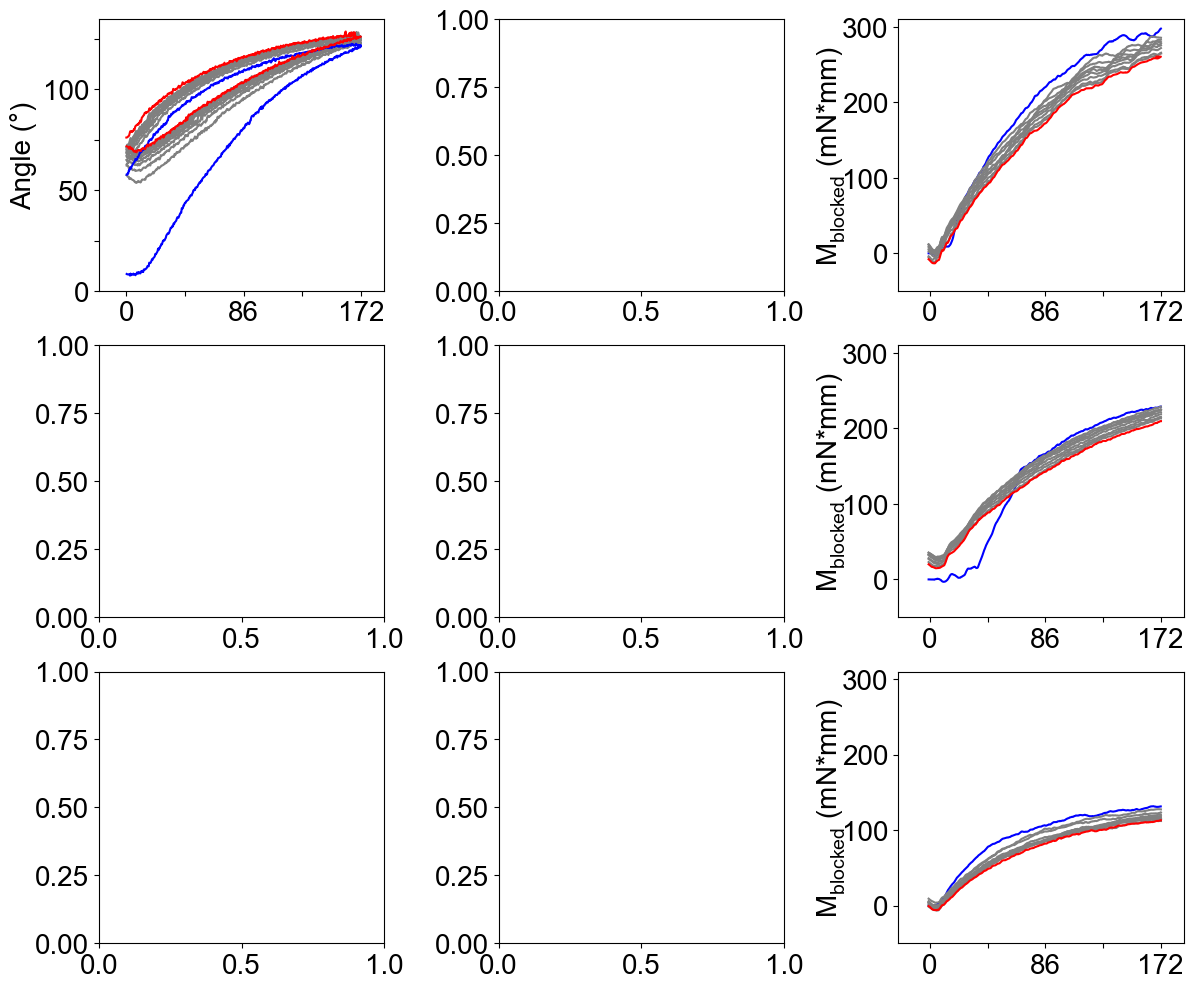

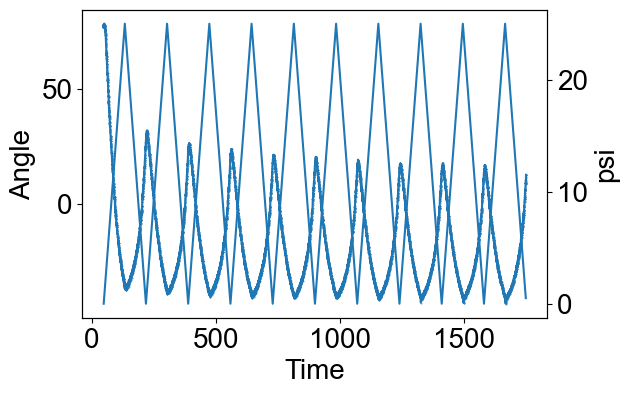

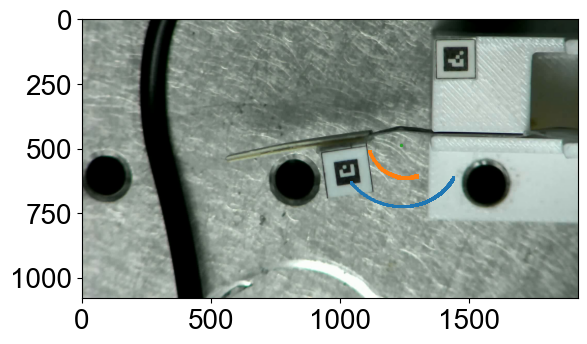

In [171]:

n_cycle = 10
base_angle = 85.

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
# fig, ax_angle = plt.subplots(2, 1, figsize=(4,8), sharey='row',gridspec_kw={'wspace': 0.14, 'hspace': 0.4})

img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    print(calc_angle_wrt_horiz(camera_data_dict['corners'][1][0]))    
    r_val = merge_PWM(values_dict['regulator_PWM2'], values_dict['regulator_PWM3'])
    r_time = times_dict['regulator_PWM2']
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][1], camera_data_dict['rot'][1], s=0.1)
    ax.plot(camera_data_dict['t'][1], camera_data_dict['rot'][1], linestyle='-')
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax1 = ax.twinx()
    ax1.plot(r_time, r_val)
    ax1.set_ylabel('psi')

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
    
    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][1][:, 0], 
            camera_data_dict['centroid'][1][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1
        )
    ax.scatter(
            camera_data_dict['centroid_offset'][1][:, 0], 
            camera_data_dict['centroid_offset'][1][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1
        )
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][1][:, :2])
    ax.scatter([xc], [yc], s=2)

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][1][:, :2]*camera_scale[0])
    # lines_circle.append(plot_circle_arc(ax, np.array([0, 0]), r, np.min(angles), np.max(angles)))
    # ax.scatter([xc]/camera_scale[0], [yc]/camera_scale[0], s=1, color='red')

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][1][camera_data_dict['angle_wrt_fixed'][1] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))
    
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_all[0][0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][1][i]
        end_idx = camera_data_dict['cycle_start_idx'][1][i+1]


        
        line = ax.plot(camera_data_dict['t_cycle'][1][start_idx:end_idx], 
                -1 * (camera_data_dict['angle_wrt_fixed'][1][start_idx:end_idx]-base_angle), 
                linestyle='-',
                label=f'#{i+1}',
                color=color
                )
        # print('minmax plot angle', np.min(-1 * (camera_data_dict['angle_wrt_fixed'][1][start_idx:end_idx]-base_angle)), 
             # np.max(-1 * (camera_data_dict['angle_wrt_fixed'][1][start_idx:end_idx]-base_angle)))
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        # ax = ax_all[0][1]
        # start_idx = camera_data_dict['cycle_start_idx'][1][i]
        # end_idx = camera_data_dict['cycle_start_idx'][1][i+1]

        # ax.scatter(
        #     (camera_data_dict['disp_offset'][1][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
        #     camera_data_dict['disp_offset'][1][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
        #     linestyle='-',
        #     label=f'Trial {i+1}',
        #     s=1,
        #     color=color
        # )
    # lines_circle.append(plot_circle_arc(ax, np.array([0, 0]), r, np.min(angles), np.max(angles), flip_x=False))


    # ax.legend()
print(lines)
for i, ax in enumerate([ax_all[0][0]]):
    # ax.set_ylim(-110, 110)
    ax.set_yticks([0, 25,50,75,100,125])
    ax.set_yticklabels(['0', '', '50', '','100',''])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][1][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                             np.min(camera_data_dict['t_cycle'][1][start_idx:end_idx]), 
                             np.max(camera_data_dict['t_cycle'][1][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['0', '', '86', '', '172'])
    
    # ax.set_title(f'{psi[i]} kPa', fontsize='24')
    # ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        # ax.set_xlabel('Pressure (kPa)', )
    # if i == 0:
    #     legend_labels = [r'1st trial', r'2-9th trial', '10th trial']
    #     legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
    #     legend = ax.legend(legend_handles, legend_labels, ncol=1, 
    #                        labelspacing=0.1, 
    #                        columnspacing =0.05,
    #                        loc='lower right', 
    #                        handletextpad=0.1, 
    #                        fontsize=fontsize_legend
    #                       )

# for i, ax in enumerate([ax_all[0][1]]):
#     ax.axis('equal')
#     ax.set_xlim(-6, 6)
#     ax.set_xticks([-5, -2.5, 0, 2.5, 5])
#     ax.set_xticklabels([ '-5', '', '0', '', '5', ])
#     ax.set_ylim(0, 5)
#     ax.set_yticks([0, 2.5, 5])
#     ax.set_yticklabels(['0', '', '5'])
    
    # ax.set_aspect('equal')
    # if i == 0:
        # ax.set_ylabel('Displacement-Y (mm)')
    # if i == 0:
        # ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    # if i == 0:
        # ax.set_xlabel('Displacement-X (mm)')

# fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

# plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
display(fig_all)

# *Exp 2-3-single

In [172]:
result_name_arr = [
    'exp_2_3_20240520_16-48-49_onedir-diamond'
    
]

n_cycle_arr = [10, 10]

ids=[0, 1, 2]
values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, result_name_arr, ids)

found prior buffer, loading from ./data-raw\exp_2_3_20240520_16-48-49_onedir-diamond\processed\load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at ./data-raw\exp_2_3_20240520_16-48-49_onedir-diamond\processed\frame_1.png. Skipping...
Image already exists at ./data-raw\exp_2_3_20240520_16-48-49_onedir-diamond\processed\frame_1000.png. Skipping...
loaded keys:  ['camera_1', 'camera_0', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'info_CYCLE_DONE', 'camera_17']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'angle_wrt_horiz', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


n cycle 10 cycle len 2


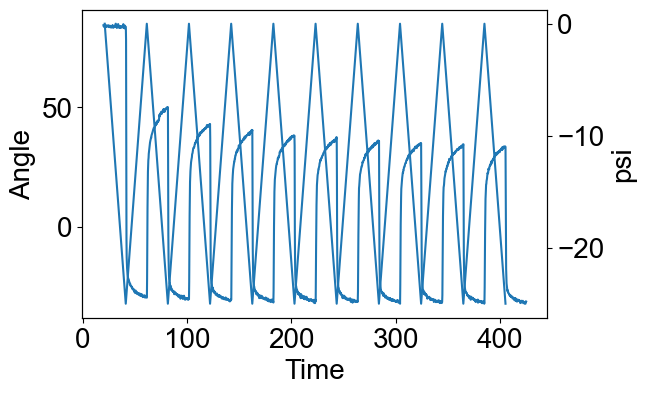

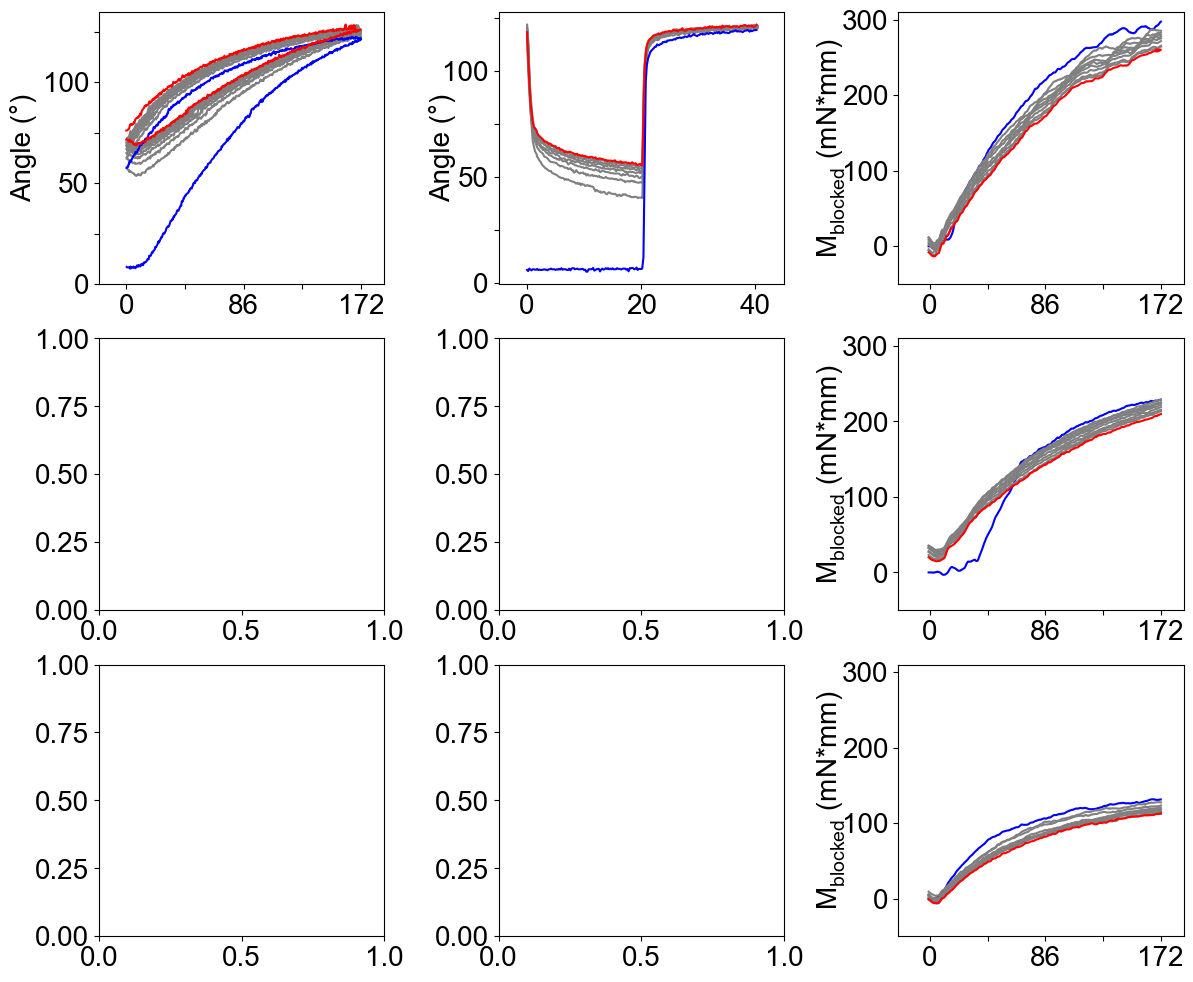

hello


In [173]:
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
# fig, ax_angle = plt.subplots(1, 1, figsize=(4,4), sharex=True, sharey=True, gridspec_kw={'wspace': 0.06})
lines = []
for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    n_cycle = n_cycle_arr[ii]
    r_val = merge_PWM(values_dict['regulator_PWM2'], values_dict['regulator_PWM3'])
    r_time = times_dict['regulator_PWM2']
    
    ax = ax_ori
    # ax.scatter(camera_data_dict['t'][1], camera_data_dict['rot'][1], s=0.1)
    ax.plot(camera_data_dict['t'][1], camera_data_dict['angle_wrt_fixed'][1], linestyle='-')
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax1 = ax.twinx()
    ax1.plot(r_time, r_val)
    ax1.set_ylabel('psi')
    
    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
    
    ax = ax_all[0][1]
    # ax1 = axes[1]
    legend_labels = []
    camera_data_dict['angle_wrt_fixed'][1][camera_data_dict['angle_wrt_fixed'][1] < -120] += 360
    
    for i in list(range(1, n_cycle-2))+[0, n_cycle-2] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-2:
            color = 'red'
        else:
            color = 'grey'
        start_idx = camera_data_dict['cycle_start_idx'][1][i]
        end_idx = camera_data_dict['cycle_start_idx'][1][i+1]

        
        # if i != 1:
        #     continue
        cur_t = camera_data_dict['t'][1][start_idx:end_idx] -camera_data_dict['t'][1][start_idx]
        cur_angle = camera_data_dict['angle_wrt_fixed'][1][start_idx:end_idx]
        cur_angle = -cur_angle+90
        
        lines.append(ax.plot(cur_t, 
                cur_angle, 
                linestyle='-',
                label=f'Trial {i+1}',
                color=color
                ))
 
        # ax1.scatter(i, camera_data_dict['rot'][1][(start_idx+end_idx)//2]-90)
        # if i == 1:
            # break
        # if i == n_cycle-2:
            # break
 

for i, ax in enumerate([ax_all[0][1]]):

    ax.set_yticks([0, 25,50,75,100,125])
    ax.set_yticklabels(['0', '', '50', '','100',''])
    ax.set_xlim(-5, 45)
    ax.set_xticks([0, 20, 40])
    
    # ax.set_title(subtitles[i], fontsize='24')
    # ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)',labelpad=-10)
        # ax.set_xlabel('Time (s)')

        
# plt.savefig(os.path.join(figures_dir, 'onedir-diamond-step.pdf'), dpi=600, bbox_inches = 'tight')
plt.show()
display(fig_all)
print('hello')

# *Exp 3-1-single 

In [174]:

result_name_arr = [
    # 'exp_3_1_single_20240325_09-37-24_single_backbone_0',
    # 'exp_3_1_single_20240325_10-34-13_single_backbone_10',
    # 'exp_3_1_single_20240325_12-57-31_single_backbone_10',
    # 'exp_3_1_single_20240325_13-52-29_single_backbone_20'
    # 'exp_3_1_single_20240325_14-54-47_single_backbone_20' # another run with different initial conditions
    # 'exp_3_1_single_20240325_11-53-28_single_backbone_20'

    # 'exp_3_1_single_20240519_14-10-41_bidir-single' # new design of actuators
    'exp_3_1_single_20240519_20-10-24_bidir-single',
    'exp_3_1_single_20240519_15-25-01_bidir-twopouch'
]

tag_offset_dict = {
    1: {
        'rot': -180,
        'disp': [3.25,-3.25]
    }
}
ids=[0, 1, 2]
values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from ./data-raw\exp_3_1_single_20240519_20-10-24_bidir-single\processed\load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at ./data-raw\exp_3_1_single_20240519_20-10-24_bidir-single\processed\frame_1.png. Skipping...
Image already exists at ./data-raw\exp_3_1_single_20240519_20-10-24_bidir-single\processed\frame_1000.png. Skipping...
loaded keys:  ['camera_1', 'camera_0', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'camera_17', 'info_CYCLE_DONE']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'angle_wrt_horiz', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])
found prior buffer, loading from ./data-raw\exp_3_1_single_20240519_15-25-01_bidir-twopouch\processed\load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exist

-131.53874612204586
n cycle 10 cycle len 200
fitted circle: x 1325.10 y 431.30 r 241.67 sigma 0.73
fitted circle: x -3.71 y 9.77 r 3.97 sigma 0.03
angles -46.84332 64.394806
angles -44.995617 63.892105
angles -44.530647 63.89563
angles -44.076344 63.451187
angles -44.071884 63.1669
angles -43.839428 63.1669
angles -43.846703 63.16455
angles -43.83832 62.94693
angles -49.16433 65.34213
angles -43.613194 63.16455
-63.86358755562412
n cycle 10 cycle len 200
fitted circle: x 1265.18 y 410.34 r 241.63 sigma 8.50
fitted circle: x -4.81 y 8.78 r 4.61 sigma 0.11
angles -114.016014 100.53122
angles -112.80279 100.34808
angles -112.59205 100.07501
angles -112.29986 99.57077
angles -111.79024 99.38182
angles -111.7959 99.244125
angles -111.795746 98.73686
angles -111.79266 99.10446
angles -117.37251 99.89197
angles -111.374245 98.74063
[[<matplotlib.lines.Line2D object at 0x000001C9A44B0AF0>], [<matplotlib.lines.Line2D object at 0x000001C9A44B0D90>], [<matplotlib.lines.Line2D object at 0x000001C9

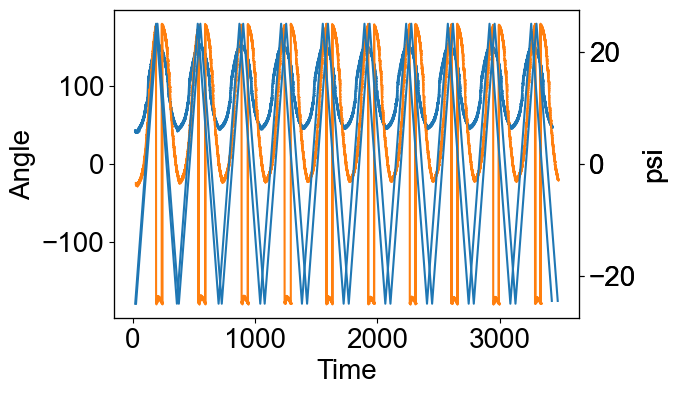

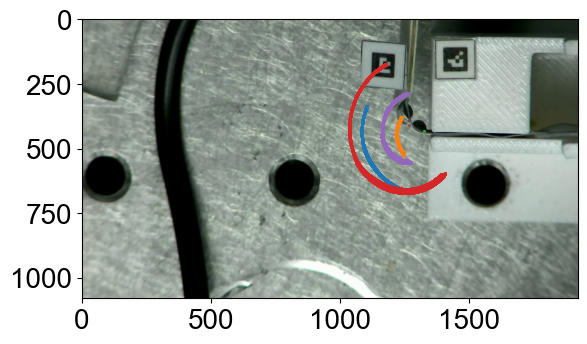

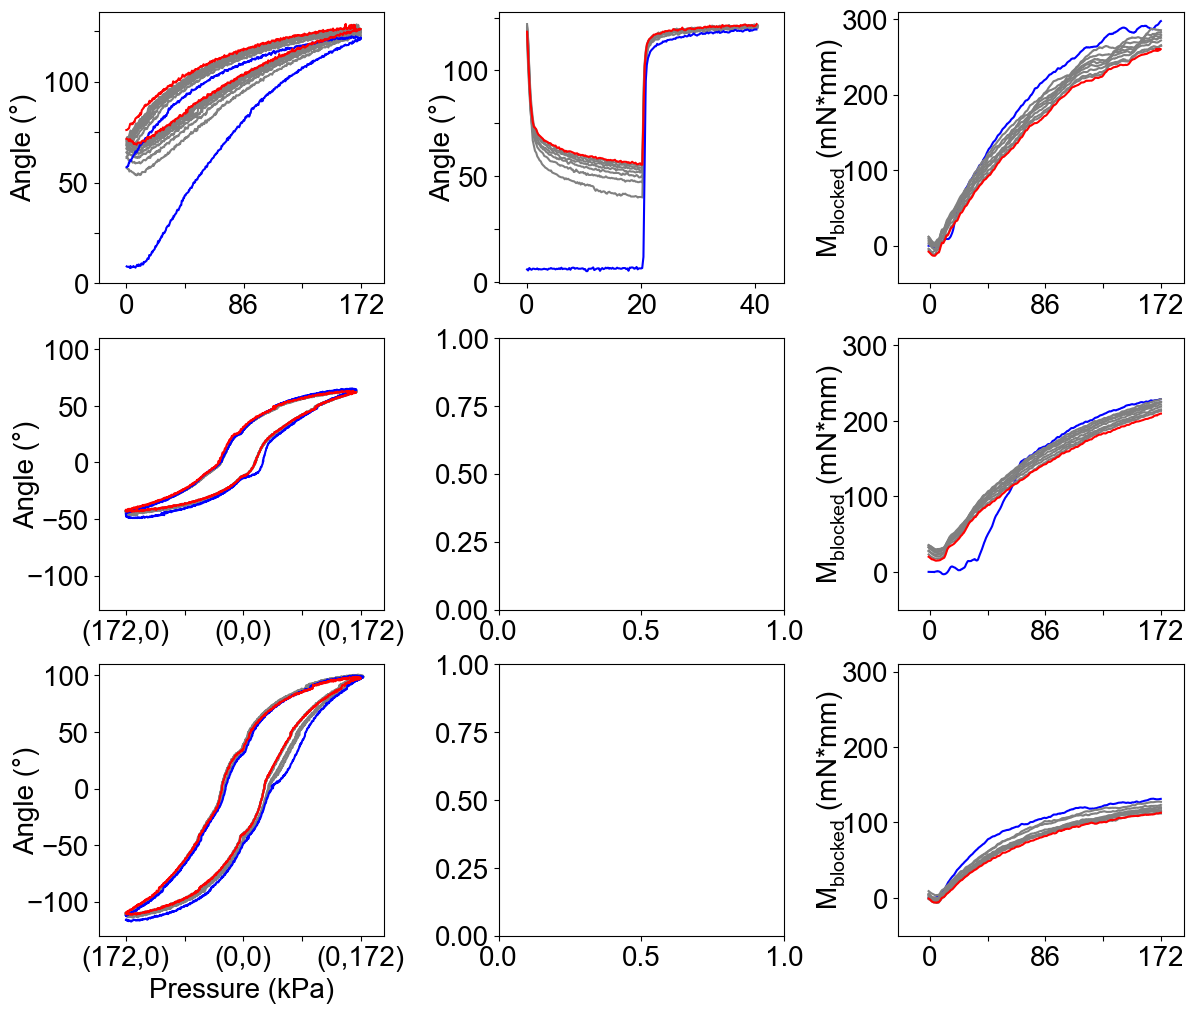

In [175]:
plt.rcParams['font.size'] = fontsize_main
n_cycle = 10
base_angle = 90.

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
# fig, ax_angle = plt.subplots(2, 2, figsize=(8,8), sharey='row',gridspec_kw={'wspace': 0.14, 'hspace': 0.2})

img = mpimg.imread(os.path.join(data_folder, result_name_arr[1], 'processed', 'frame_1000.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    # all_keys = ['t', 'rot', 'disp', 'centroid', 'angle_wrt_fixed']
    # for key in all_keys:
    #     if 2 in camera_data_dict[key]:
    #         camera_data_dict[key][1] = camera_data_dict[key][2]  
    
    print(calc_angle_wrt_horiz(camera_data_dict['corners'][1][0]))    
    r_val = merge_PWM(values_dict['regulator_PWM2'], values_dict['regulator_PWM3'])
    r_time = times_dict['regulator_PWM2']
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][1], camera_data_dict['rot'][1], s=0.1)
    ax.plot(camera_data_dict['t'][1], camera_data_dict['rot'][1], linestyle='-')
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax1 = ax.twinx()
    ax1.plot(r_time, r_val)
    ax1.set_ylabel('psi')

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
    
    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][1][:, 0], 
            camera_data_dict['centroid'][1][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1
        )
    ax.scatter(
            camera_data_dict['centroid_offset'][1][:, 0], 
            camera_data_dict['centroid_offset'][1][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1
        )
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][1][:, :2])
    ax.scatter([xc], [yc], s=2)

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][1][:, :2]*camera_scale[0])
    # lines_circle.append(plot_circle_arc(ax, np.array([0, 0]), r, np.min(angles), np.max(angles)))
    # ax.scatter([xc]/camera_scale[0], [yc]/camera_scale[0], s=1, color='red')

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][1][camera_data_dict['angle_wrt_fixed'][1] < -120] += 360
    # print('angles', np.min(angles), np.max(angles))
    
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_all[ii+1][0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][1][i]
        end_idx = camera_data_dict['cycle_start_idx'][1][i+1]

        print('angles', np.min( camera_data_dict['angle_wrt_fixed'][1][start_idx:end_idx]-base_angle), 
              np.max( camera_data_dict['angle_wrt_fixed'][1][start_idx:end_idx]-base_angle, ))
        
        line = ax.plot(camera_data_dict['t_cycle'][1][start_idx:end_idx], 
                camera_data_dict['angle_wrt_fixed'][1][start_idx:end_idx]-base_angle, 
                linestyle='-',
                label=f'#{i+1}',
                color=color
                )
     
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_all[ii+1][1]
        start_idx = camera_data_dict['cycle_start_idx'][1][i]
        end_idx = camera_data_dict['cycle_start_idx'][1][i+1]

        # ax.scatter(
        #     -1 * (camera_data_dict['disp_offset'][1][start_idx:end_idx, 1]*camera_scale[0]-yc),#-base_disp[0], 
        #     -1*(camera_data_dict['disp_offset'][1][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
        #     linestyle='-',
        #     label=f'Trial {i+1}',
        #     s=1,
        #     color=color
        # )
    
    # lines_circle.append(plot_circle_arc(ax, np.array([0, 0]), r, np.min(angles), np.max(angles), flip_xy=True, flip_x=True))
    # if ii == 1:
        # plot_circle_arc(ax_3[1], np.array([0, 0]), r, np.min(angles), np.max(angles), flip_xy=True, flip_x=True)


    # ax.legend()
print(lines)
subtitle = ['Single pouch', 'Double pouch']
for i, ax in enumerate([ax_all[1][0],ax_all[2][0]]):
    ax.set_ylim(-130, 110)
    ax.set_yticks([-100, -50, 0, 50,100])
    ax.set_xlim(-20, np.max(camera_data_dict['t_cycle'][1][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                             np.min(camera_data_dict['t_cycle'][1][start_idx:end_idx]), 
                             np.max(camera_data_dict['t_cycle'][1][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    if i == 1 or i == 2:
        ax.set_xlabel('Pressure (kPa)', )
    
    # ax.set_title(subtitle[i], fontsize=fontsize_main)
    # ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

    ax.set_ylabel('Angle (°)', labelpad=-10)
  

    # if i == 2:
    #     legend_labels = [r'1st trial', r'2-9th trial', '10th trial']
    #     legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
    #     legend = ax.legend(legend_handles, legend_labels, ncol=1, 
    #                        labelspacing=0.1, 
    #                        columnspacing =0.05,
    #                        loc='upper right', 
    #                        handletextpad=0.1, 
    #                        fontsize=fontsize_legend,
    #                       )

# for i, ax in enumerate([ax_all[1][1],ax_all[2][1]]):
#     ax.axis('equal')
#     ax.set_xlim(-6, 6)
#     ax.set_xticks([-5, -2.5, 0, 2.5, 5])
#     ax.set_xticklabels(['-5', '', '0', '', '5'])
#     ax.set_ylim(-3.5, 8.5)
#     ax.set_yticks([0, 2.5, 5])
#     ax.set_yticklabels(['0', '', '5',])
    
    # ax.set_aspect('equal')
    # ax.set_ylabel('Displacement-Y (mm)', )
    # if i == 2:
        # ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    # if i == 1 or i == 2:
        # ax.set_xlabel('Displacement-X (mm)', )

# fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

# plt.savefig(os.path.join(figures_dir, 'bidir-single-cont.pdf'), dpi=600)
plt.show()
display(fig_all)


# *Exp 3-3-1 (single bidir actuator actuation)

In [176]:
result_name_arr = [
    # 'exp_3_3_single_20240325_17-54-28_timeout_20_backbone_0',
    # 'exp_3_3_single_20240325_18-22-31_timeout_20_backbone_10',
    # 'exp_3_3_single_20240325_18-28-35_timeout_20_backbone_20'
    # 'exp_3_3_single_20240519_21-08-15_bidir-single',
   
    
    'exp_3_3_single_20240520_16-28-43_bidir-single', # 10 trials
    # 'exp_3_3_single_20240520_17-45-12_bidir-twopouch',
    'exp_3_3_single_20240520_18-06-50_bidir-twopouch',
    # 'exp_2_3_20240520_16-48-49_onedir-diamond'
    
]

n_cycle_arr = [10, 10]

ids=[0, 1, 2]
values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, result_name_arr, ids)

found prior buffer, loading from ./data-raw\exp_3_3_single_20240520_16-28-43_bidir-single\processed\load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at ./data-raw\exp_3_3_single_20240520_16-28-43_bidir-single\processed\frame_1.png. Skipping...
Image already exists at ./data-raw\exp_3_3_single_20240520_16-28-43_bidir-single\processed\frame_1000.png. Skipping...
loaded keys:  ['camera_1', 'camera_0', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'info_CYCLE_DONE', 'camera_17', 'camera_42']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'angle_wrt_horiz', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])
found prior buffer, loading from ./data-raw\exp_3_3_single_20240520_18-06-50_bidir-twopouch\processed\load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image 

n cycle 10 cycle len 4
n cycle 10 cycle len 4


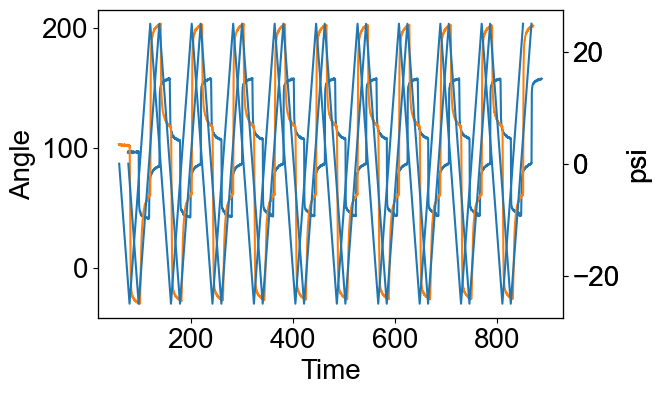

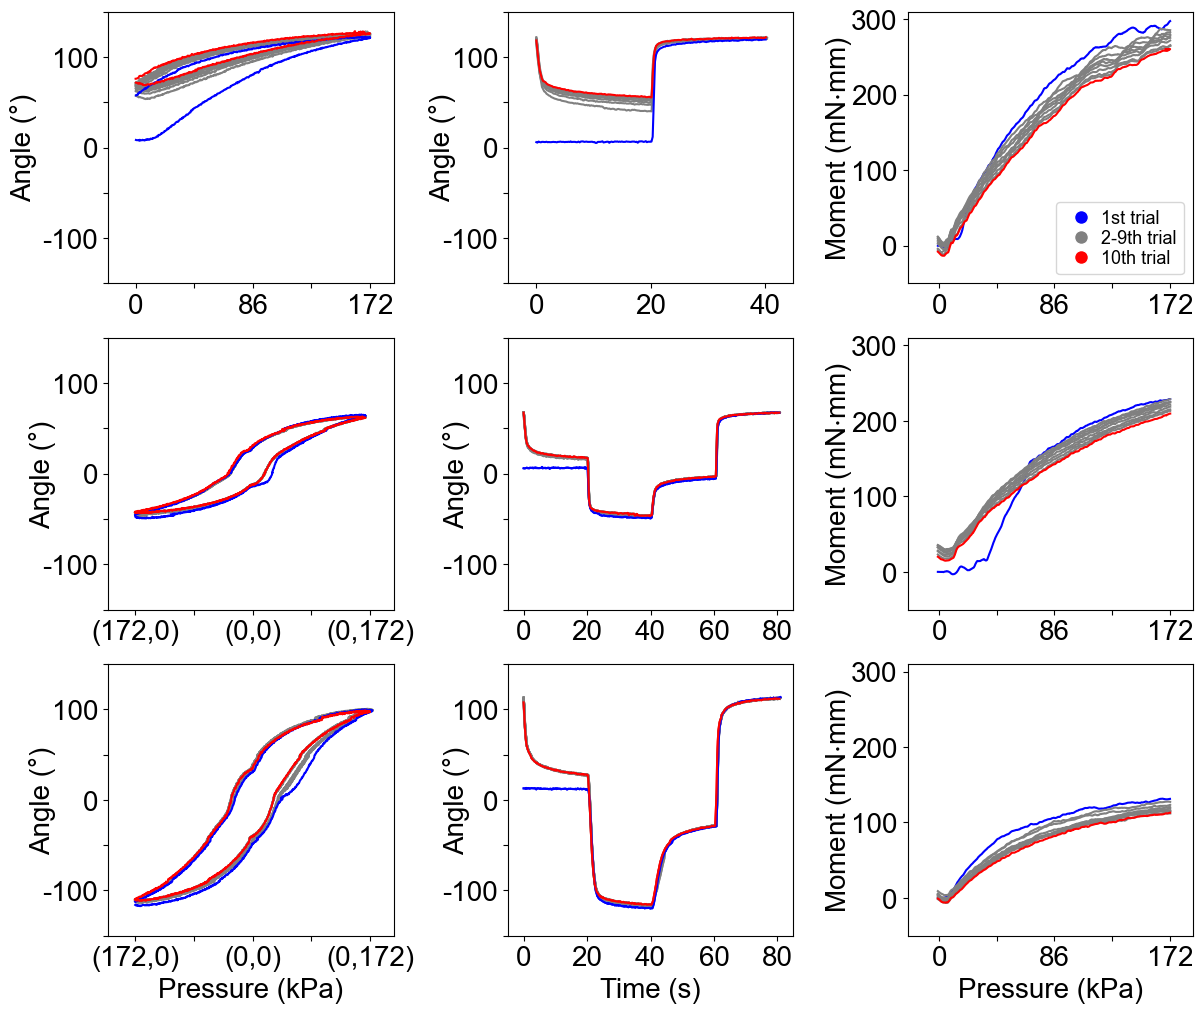

In [178]:
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
# fig, ax_angle = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True, gridspec_kw={'wspace': 0.06})
lines = []
for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    n_cycle = n_cycle_arr[ii]
    r_val = merge_PWM(values_dict['regulator_PWM2'], values_dict['regulator_PWM3'])
    r_time = times_dict['regulator_PWM2']
    
    ax = ax_ori
    # ax.scatter(camera_data_dict['t'][1], camera_data_dict['rot'][1], s=0.1)
    ax.plot(camera_data_dict['t'][1], camera_data_dict['angle_wrt_fixed'][1], linestyle='-')
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax1 = ax.twinx()
    ax1.plot(r_time, r_val)
    ax1.set_ylabel('psi')
    
    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
    
    ax = ax_all[ii+1][1]
    # ax1 = axes[1]
    legend_labels = []
    camera_data_dict['angle_wrt_fixed'][1][camera_data_dict['angle_wrt_fixed'][1] < -120] += 360
    
    for i in list(range(1, n_cycle-2))+[0, n_cycle-2] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-2:
            color = 'red'
        else:
            color = 'grey'
        start_idx = camera_data_dict['cycle_start_idx'][1][i]
        end_idx = camera_data_dict['cycle_start_idx'][1][i+1]

        
        # if i != 1:
        #     continue
        cur_t = camera_data_dict['t'][1][start_idx:end_idx] -camera_data_dict['t'][1][start_idx]
        cur_angle = camera_data_dict['angle_wrt_fixed'][1][start_idx:end_idx]-90
        lines.append(ax.plot(cur_t, 
                cur_angle, 
                linestyle='-',
                label=f'Trial {i+1}',
                color=color
                ))
ax_all[2][2].set_xlabel('Pressure (kPa)')

ax = ax_all[0][2]
legend_labels = [r'1st trial', r'2-9th trial', '10th trial']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                           labelspacing=0.1, 
                           columnspacing =0.05,
                           loc='lower right', 
                           handletextpad=0.1, 
                           fontsize=fontsize_legend-1
                          )
for ax in ax_all[:, 2]:
    ax.set_ylabel('Moment (mN$\cdot$mm)', labelpad=-2)

subtitles = ['Single pouch', 'Double pouch']
for i, ax in enumerate([ax_all[1][1],ax_all[2][1]]):
    # ax.set_ylim(-130, 50)
    # ax.set_yticks([-100, -50, 0, 50])

    ax.set_xlim(-5, 85)
    ax.set_xticks([0, 20, 40, 60,80])

    ax.set_ylim(-130, 130)
    ax.set_yticks([-100, -50, 0, 50,100])
    ax.set_yticklabels(['-100', '', '0','', '100'])


    ax.set_ylabel('Angle (°)',labelpad=-20)
    if i == 1 or i == 2:
        ax.set_xlabel('Time (s)')

for i, ax_arr in enumerate(ax_all):
    ax = ax_arr[0]
    ax.set_ylim(-150,150)
    ax.set_yticks([-150, -100, -50, 0, 50,100, 150])
    ax.set_yticklabels(['', '-100', '', '0','', '100', ''])

    # ax = ax_arr[1]
    # ax.axis('equal')
    # ax.set_xlim(-6, 6)
    # ax.set_xticks([-5, -2.5, 0, 2.5, 5])
    # ax.set_xticklabels(['-5', '', '0', '', '5'])
    # ax.set_xlim(-6, 6)
    # ax.set_xticks([-5, -2.5, 0, 2.5, 5])
    # ax.set_xticklabels(['-5', '', '0', '', '5'])

    
    ax = ax_arr[1]
    ax.set_ylim(-150,150)
    ax.set_yticks([-150, -100, -50, 0, 50,100, 150])
    ax.set_yticklabels(['', '-100', '', '0','', '100', ''])
    
fig_all.savefig(os.path.join(figures_dir, 'char-all-actuators-force.pdf'), dpi=600, bbox_inches = 'tight')

plt.show()
display(fig_all)
